# Análisis morfológico urbano: densidad y orientación de edificaciones en CABA

## 📦 1. Importar librerías, preparar datos y visualización inicial

In [1]:
# === 1. LIBRERÍAS ===
# Cargamos todas las librerías necesarias para el análisis
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
from shapely.geometry import box
from shapely.affinity import rotate
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import osmnx as ox
from shapely.wkt import loads
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [2]:
# === 2. CARGA DE DATOS ===
# Cargar CSV con geometría WKT, solamente abro las columnas que voy a usar para optimizar 
df = pd.read_csv("95b_buildings.csv/95b_buildings.csv", usecols=["latitude", "longitude", "geometry", "area_in_meters"])

# ⚠️ Paciencia: este chunk puede tardar un rato largo en ejecutarse 
df['geometry'] = df['geometry'].apply(wkt.loads)

# Lo convertimos en un GeoDataFrame
buildings = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Reproyectamos a EPSG:9498 (metros). Específico para el área de Buenos Aires.
buildings = buildings.to_crs("EPSG:9498") 

### 📍 Recorte espacial del área de análisis

Dado que el dataset de Google Open Buildings cubre una región muy amplia del AMBA (e incluso más), decidimos **restringir el análisis a la Ciudad Autónoma de Buenos Aires (CABA)** por cuestiones de rendimiento computacional.

Además, para facilitar la **visualización de los resultados** (densidad y orientación edilicia), se seleccionó una **subzona dentro de CABA** como muestra representativa.  

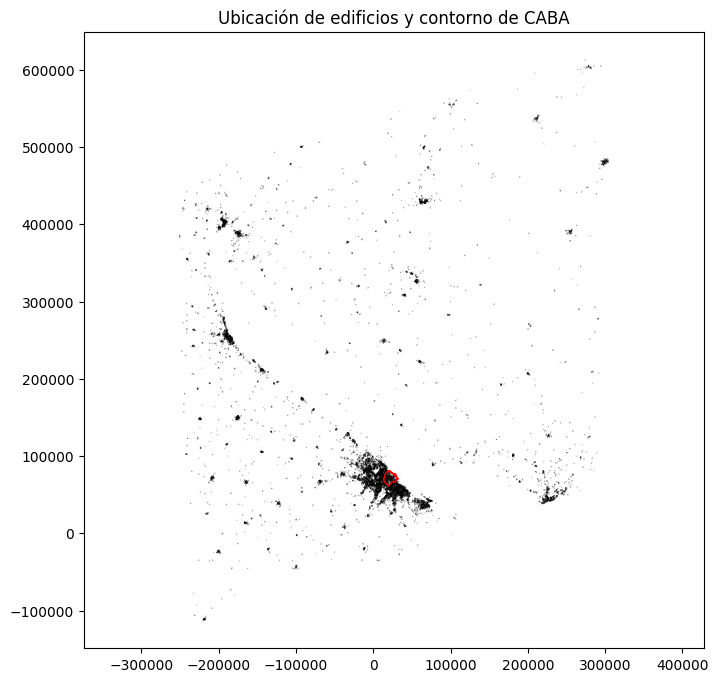

In [3]:
# === 3. FILTRADO POR CABA ===
# Descargar el polígono de CABA desde openstreet map 
caba = ox.geocode_to_gdf("Ciudad Autónoma de Buenos Aires, Argentina")
caba = caba.to_crs("EPSG:9498")  # Me aseguro que esté en el mismo CRS que los datos

# Filtrar los edificios que están dentro del polígono de CABA
caba_union = caba.geometry.union_all()
buildings_caba = buildings[buildings.geometry.intersects(caba_union)]

fig, ax = plt.subplots(figsize=(8, 8))
caba.boundary.plot(ax=ax, color='red', linewidth=1)
buildings.sample(10000).plot(ax=ax, facecolor='lightblue', edgecolor='black', markersize=1)
plt.title("Ubicación de edificios y contorno de CABA")
plt.axis("equal")
plt.show()

In [4]:
# elimino df y buildings para que no me ocupe lugar en memoria
del df
del buildings

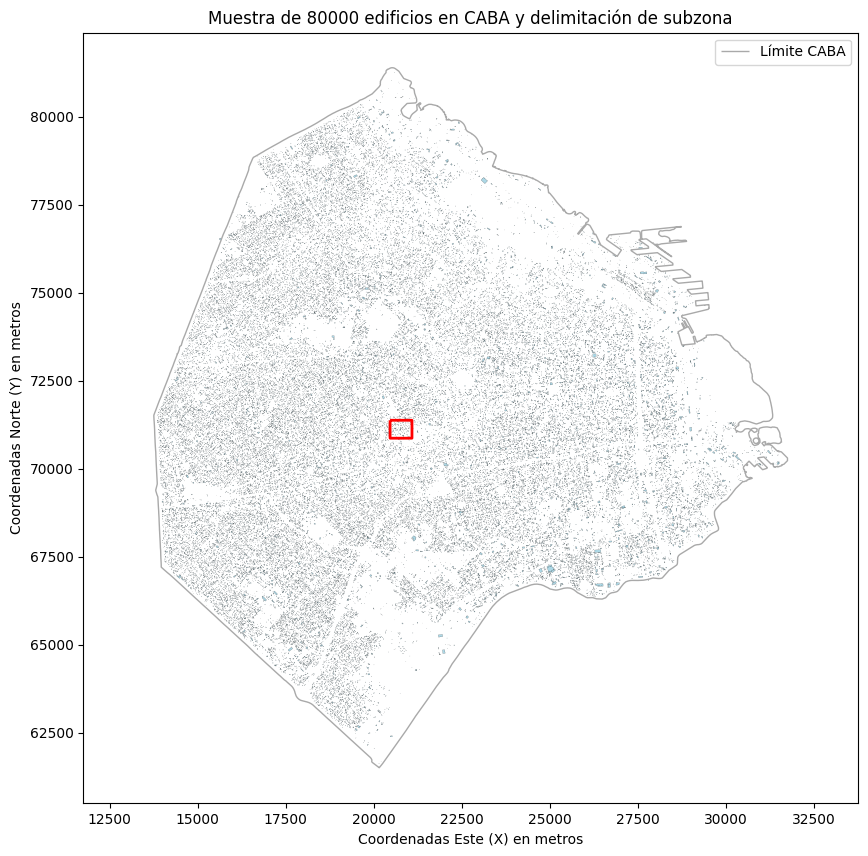

In [5]:
# === 4. RECORTE DE UNA ZONA ESPECÍFICA ===
# Polígono de interés en formato WKT
wkt_poly = "POLYGON((-58.458261202722085 -34.61683847388933,-58.451480578332436 -34.61683847388933,-58.451480578332436 -34.621429689148954,-58.458261202722085 -34.621429689148954,-58.458261202722085 -34.61683847388933))"

# Crear el polígono como objeto shapely y reproyectar
zona = loads(wkt_poly)
zona = gpd.GeoDataFrame(geometry=[loads(wkt_poly)], crs="EPSG:4326")
zona = zona.to_crs("EPSG:9498")
 
# Filtrar los edificios dentro del polígono
buildings_zona = buildings_caba[buildings_caba.geometry.within(zona.geometry.iloc[0])]

# Tomar una muestra aleatoria de edificios para graficar toda la CABA
sample_size = 80000
subset = buildings_caba.sample(sample_size, random_state=42)

fig, ax = plt.subplots(figsize=(10, 10))

# Edificios
subset.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=0.1, label="Edificios")

# Límite de CABA
caba.boundary.plot(ax=ax, edgecolor='darkgrey', linewidth=1.0, label="Límite CABA")

# Contorno de la zona de interés
zona.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label="Zona seleccionada")

# Estilo
plt.title(f"Muestra de {sample_size} edificios en CABA y delimitación de subzona")
plt.axis("equal")
plt.xlabel("Coordenadas Este (X) en metros")
plt.ylabel("Coordenadas Norte (Y) en metros")
plt.legend()
plt.show()

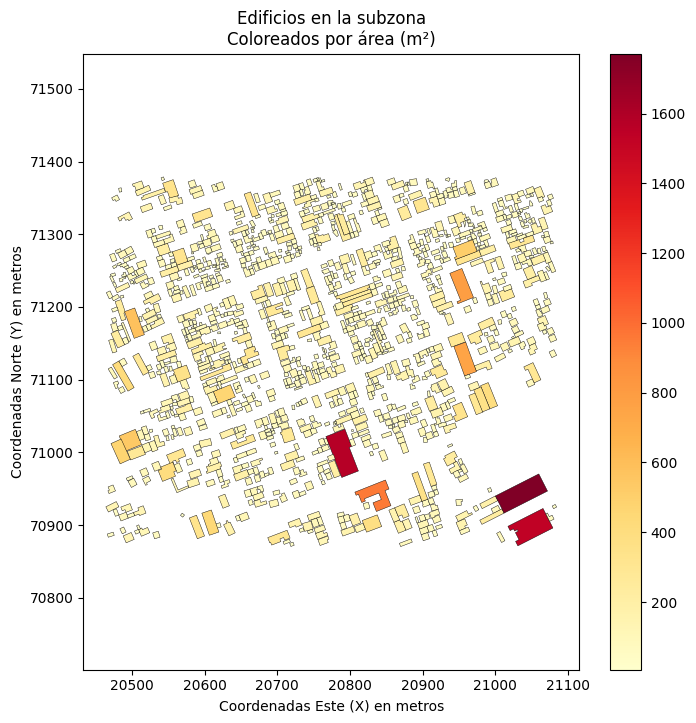

In [6]:
# === 5. Visualización con detalle===
# Graficar edificios con color según área
fig, ax = plt.subplots(figsize=(8, 8))
buildings_zona.plot(
    ax=ax,
    column='area_in_meters',            # columna usada para color
    cmap='YlOrRd',              # paleta 
    edgecolor='black',
    linewidth=0.3,
    legend=True                 # muestra la escala de colores
)

plt.title("Edificios en la subzona\nColoreados por área (m²)")
plt.xlabel("Coordenadas Este (X) en metros")
plt.ylabel("Coordenadas Norte (Y) en metros")
plt.axis("equal")
plt.show()

## 🏢 2. Densidad Edilicia

Calcular la orientación dominante de cada edificio y promediarla por celda para generar una cuadrícula con orientaciones promedio.

In [7]:
# === 1. Crear una grilla de 10×10 metros. ===
# Resolución
grid_size = 10

# Bounding box 
minx, miny, maxx, maxy = buildings_caba.total_bounds

# Coordenadas de grilla
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

# Crear la grilla 
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_coords for y in y_coords]

# Crear GeoDataFrame con la grilla
grid = gpd.GeoDataFrame(geometry=grid_cells, crs=buildings_caba.crs)

# Clip la grilla al límite de CABA
grid = gpd.overlay(grid, caba, how='intersection')

# Asegurate de que 'grid_zona' y 'grid' estén en el mismo CRS
grid = grid.to_crs(caba.crs)

# Recortar la grilla a la subzona
grid_zona = gpd.overlay(grid, zona, how='intersection')
grid_zona = grid_zona.to_crs(caba.crs)


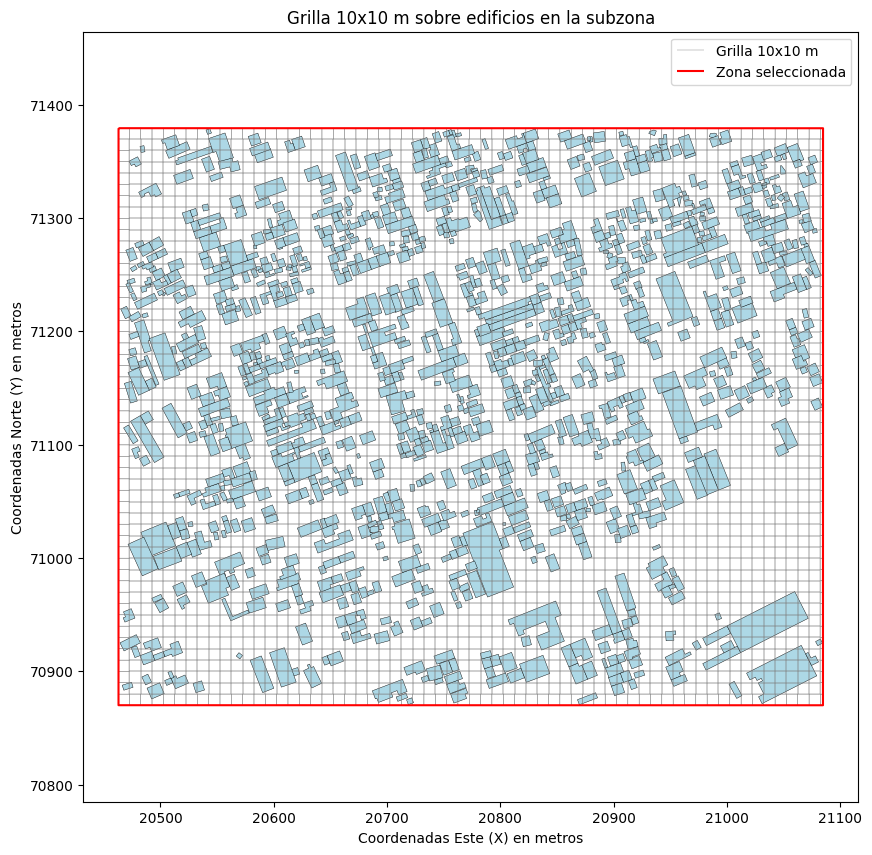

In [8]:
# === 2. Visualización de la grilla. ===
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar la grilla recortada, los edificios en la zona, el polígono de zona
grid_zona.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', label='Grilla 10x10 m')
buildings_zona.plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=0.3, label='Edificios')
zona.boundary.plot(ax=ax, color='red', linewidth=1.5, label='Zona seleccionada')

plt.title("Grilla 10x10 m sobre edificios en la subzona")
plt.axis("equal")
plt.xlabel("Coordenadas Este (X) en metros")
plt.ylabel("Coordenadas Norte (Y) en metros")
plt.legend()
plt.show()

In [9]:
# === 3. Cálculo de densidad edilicia por celda. ===

# Intersección: qué parte de cada edificio cae en cada celda
intersecciones = gpd.overlay(grid, buildings_zona, how='intersection')

# calculo el area de cada interseccion
intersecciones['area_edificio'] = intersecciones.geometry.area

# Defino un ID por celda 
grid = grid.reset_index().rename(columns={"index": "cell_id"})
intersecciones = gpd.sjoin(intersecciones, grid, how="left", predicate="within")

# Sumar el área construida por celda
area_por_celda = intersecciones.groupby('cell_id')['area_edificio'].sum().reset_index()

# Unir al GeoDataFrame de grilla
grid = grid.merge(area_por_celda, on='cell_id', how='left')

# Reemplazar NaN por 0 (celdas sin edificios)
grid['area_edificio'] = grid['area_edificio'].fillna(0)

# Calcular densidad edilicia
grid['densidad'] = grid['area_edificio'] / (10 * 10)  # celda de 100 m²


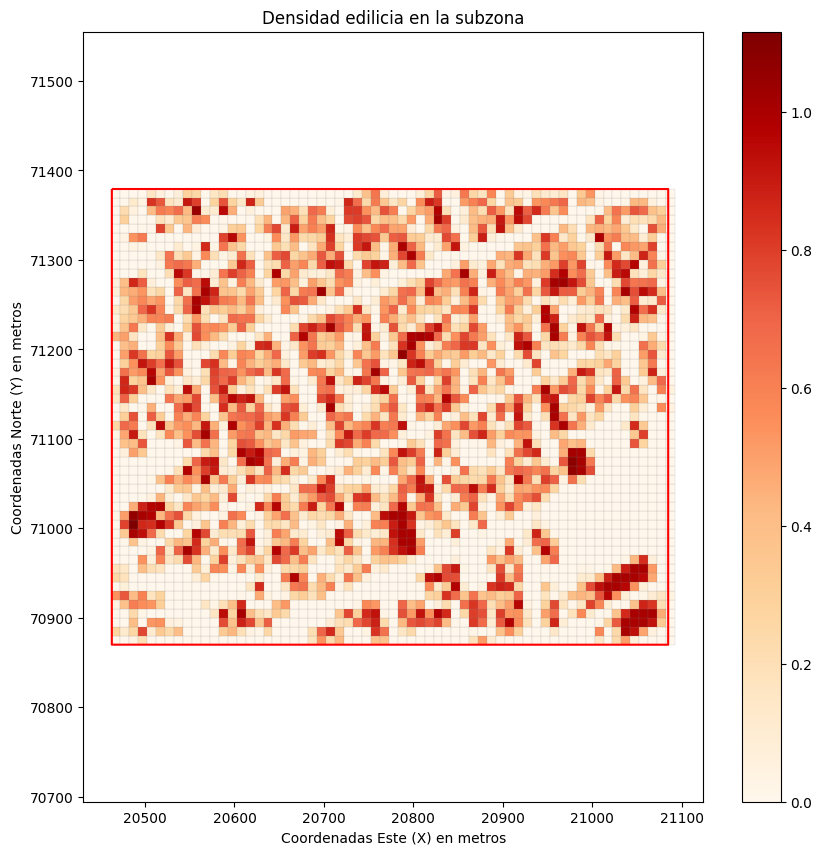

In [10]:
# === 4. Visualización de densidad edilicia en la subzona. ===

# Filtrar las celdas de grid que intersectan con zona
grid_en_zona = grid[grid.geometry.intersects(zona.geometry.iloc[0])]

fig, ax = plt.subplots(figsize=(10, 10))

grid_en_zona.plot(
    column='densidad',
    ax=ax,
    cmap='OrRd',
    legend=True,
    edgecolor='gray',
    linewidth=0.1
)

zona.boundary.plot(ax=ax, color='red', linewidth=1.5)

plt.title("Densidad edilicia en la subzona")
plt.axis("equal")
plt.xlabel("Coordenadas Este (X) en metros")
plt.ylabel("Coordenadas Norte (Y) en metros")
plt.show()

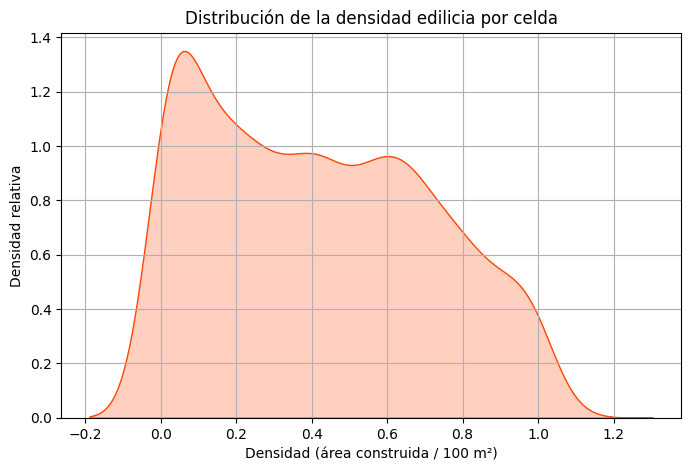

In [11]:
# === 5. Grafico de densidad de la distribucion de la densidad edilicia en todo CABA. ===

## los valores de densidad menores que 0 o mayores que 1 son producto de la funcion de densidad que suaviza, pero no son valores reales
# Asegurate de que no haya valores nulos
densidades = grid['densidad']
densidades_no_cero = densidades[densidades > 0]

# Crear el gráfico de densidad
plt.figure(figsize=(8, 5))
sns.kdeplot(densidades_no_cero, fill=True, color='orangered')
plt.title("Distribución de la densidad edilicia por celda")
plt.xlabel("Densidad (área construida / 100 m²)")
plt.ylabel("Densidad relativa")
plt.grid(True)
plt.show()


In [12]:
# === 6. Guardado de archivo ===
# Crear carpeta si no existe
os.makedirs("output", exist_ok=True)

# Guardar como GeoJSON
grid.to_file("output/densidad_edilicia.geojson", driver='GeoJSON')
 
# Guardar como Shapefile (.shp)
# grid.to_file("output/densidad_edilicia.shp")

## 🧭 3. Orientación edilicia

En esta parte se estima la orientación dominante de cada edificio utilizando análisis de componentes principales (PCA).  
Luego, se calcula la **orientación promedio** de los edificios dentro de cada celda de la grilla.

El resultado se representa en el mapa mediante colores (escala cíclica) y flechas de orientación individuales.

In [13]:
# === 1. Defino la función para el cálculo de la orientación de un poligono ===

def obtener_orientacion(geom):
    if geom.is_empty or geom.geom_type != 'Polygon':
        return np.nan

    # Extraer coordenadas de la envolvente exterior
    coords = np.array(geom.exterior.coords)
    
    # Centrar los datos
    coords_centered = coords - coords.mean(axis=0)
    
    # PCA
    pca = PCA(n_components=2)
    pca.fit(coords_centered)
    
    # Obtener el vector principal
    vector_principal = pca.components_[0]
    
    # Calcular ángulo con respecto al eje X
    angle = np.arctan2(vector_principal[1], vector_principal[0])
    angle_deg = np.degrees(angle)
    
    # Normalizar a 0–180°
    angle_deg = angle_deg % 180
    return angle_deg

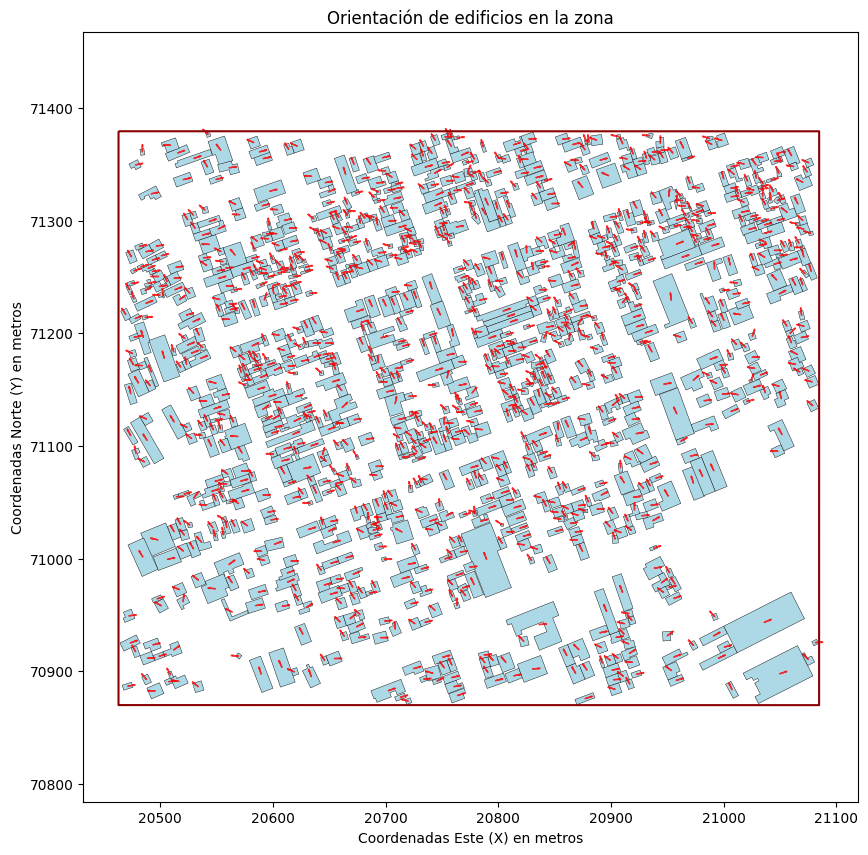

In [14]:
# === 2. Calculo las orientaciones y visualizo para la subzona ===

buildings_caba['orientacion'] = buildings_caba.geometry.apply(obtener_orientacion)

buildings_zona['orientacion'] = buildings_zona.geometry.apply(obtener_orientacion)
buildings_zona['centroide'] = buildings_zona.geometry.centroid

# Longitud de flecha (en metros)
longitud = 5

# Calcular componentes x, y del vector desde el ángulo
buildings_zona['dx'] = longitud * np.cos(np.radians(buildings_zona['orientacion']))
buildings_zona['dy'] = longitud * np.sin(np.radians(buildings_zona['orientacion']))

fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar edificios
buildings_zona.plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=0.3)

# Agregar flechas de orientación
for _, row in buildings_zona.iterrows():
    x = row['centroide'].x
    y = row['centroide'].y
    dx = row['dx']
    dy = row['dy']
    ax.arrow(x, y, dx, dy, head_width=1, head_length=2, fc='red', ec='red', alpha=0.8)

# Contorno de la zona
zona.boundary.plot(ax=ax, color='darkred', linewidth=1.5)

plt.title("Orientación de edificios en la zona")
plt.axis("equal")
plt.xlabel("Coordenadas Este (X) en metros")
plt.ylabel("Coordenadas Norte (Y) en metros")
plt.show()

In [15]:
# === 3. Cálculo de la orientación promedio por celda de la grilla ===

# Uno los edificios con celdas (divido un edificio si esta incluido en mas de una celda)
buildings_celdas = gpd.sjoin(buildings_caba, grid, how='inner', predicate='intersects')

# Calculo la orientación promedio de los edificios por celda
orientacion_promedio = (
    buildings_celdas.groupby('cell_id')['orientacion']
    .mean()
    .reset_index()
    .rename(columns={'orientacion': 'orientacion_promedio'})
)

# Asigno los valores promedio a la grilla
grid_orientado  = grid.merge(orientacion_promedio, on='cell_id', how='inner')


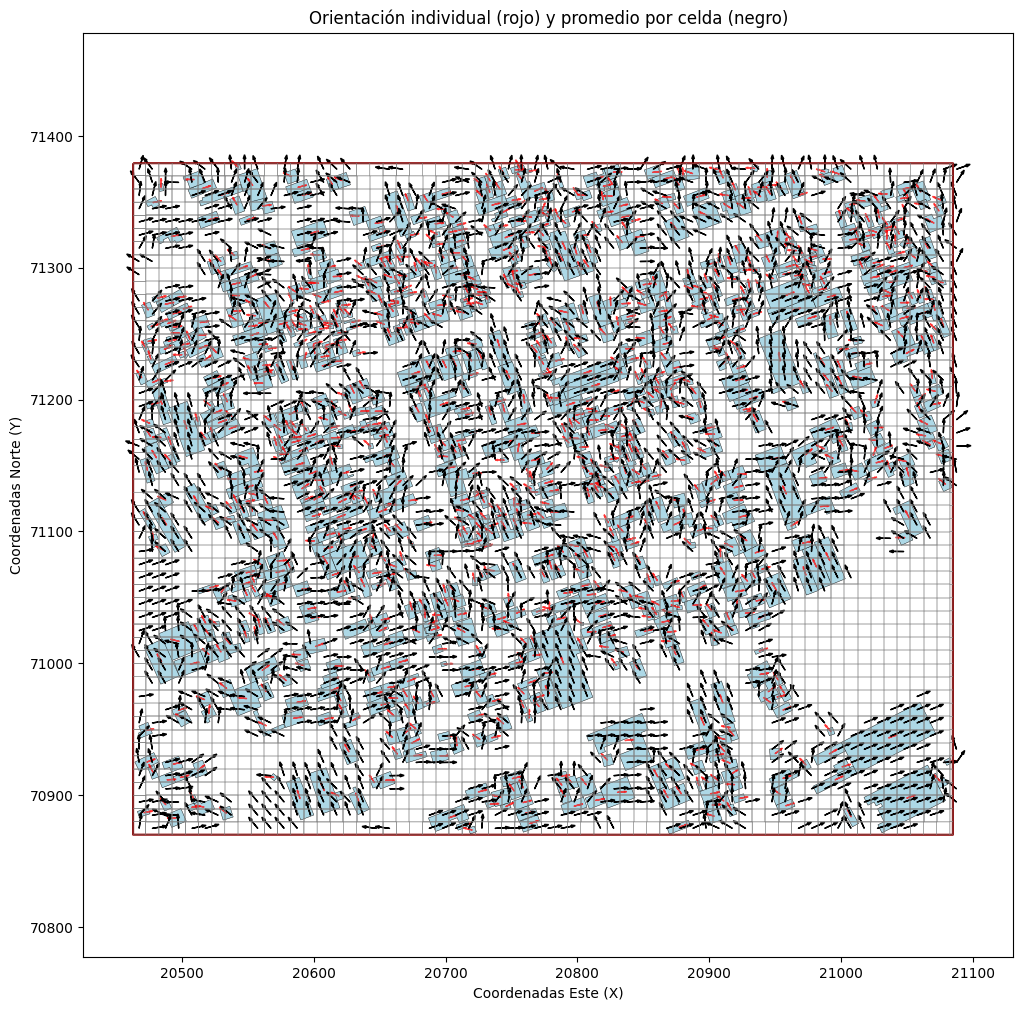

In [16]:

# === 4. Visualización de orientación edilicia (flechas de orientación y color) ===

# Calculo los centroides para graficar flechas
grid_orientado['centroide'] = grid_orientado.geometry.centroid

# Longitud de flecha para celda 
long_celda = 8

# Calcular componentes de la flecha
grid_orientado['dx'] = long_celda * np.cos(np.radians(grid_orientado['orientacion_promedio']))
grid_orientado['dy'] = long_celda * np.sin(np.radians(grid_orientado['orientacion_promedio']))

# Recortar grilla orientada solo a la zona para la visualizacion
grid_orientado_zona = gpd.overlay(grid_orientado, zona, how='intersection')

fig, ax = plt.subplots(figsize=(12, 12))

# Usar la grilla recortada
grid_orientado_zona.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.3)
buildings_zona.plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=0.3)

# Flechas individuales por edificio
for _, row in buildings_zona.iterrows():
    ax.arrow(row['centroide'].x, row['centroide'].y,
             row['dx'], row['dy'],
             head_width=1, head_length=2,
             fc='red', ec='red', alpha=0.7)

# Flechas promedio por celda (solo zona)
for _, row in grid_orientado_zona.iterrows():
    if not np.isnan(row['orientacion_promedio']):
        ax.arrow(row['centroide'].x, row['centroide'].y,
                 row['dx'], row['dy'],
                 head_width=2, head_length=3,
                 fc='black', ec='black')

# Contornos
zona.boundary.plot(ax=ax, color='darkred', linewidth=1.5)
grid_zona.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', label='Grilla 10x10 m')

plt.title("Orientación individual (rojo) y promedio por celda (negro)")
plt.axis("equal")
plt.xlabel("Coordenadas Este (X)")
plt.ylabel("Coordenadas Norte (Y)")
plt.show()


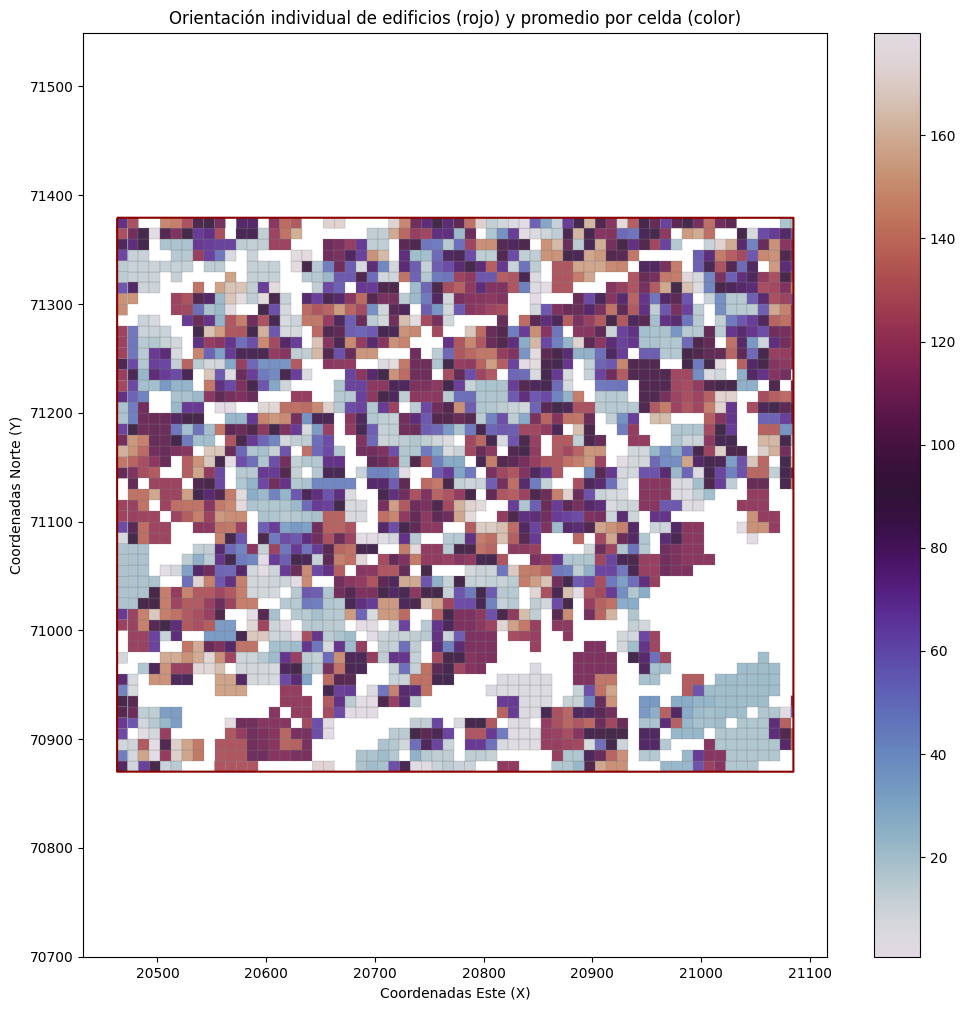

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

# Celdas dentro de la zona, coloreadas por orientación promedio
grid_orientado_zona.plot(
    column='orientacion_promedio',
    cmap='twilight',
    ax=ax,
    legend=True,
    edgecolor='gray',
    linewidth=0.2,
    alpha=0.9
)

#Contorno de la zona
zona.boundary.plot(ax=ax, color='darkred', linewidth=1.5)

plt.title("Orientación individual de edificios (rojo) y promedio por celda (color)")
plt.axis("equal")
plt.xlabel("Coordenadas Este (X)")
plt.ylabel("Coordenadas Norte (Y)")
plt.show()


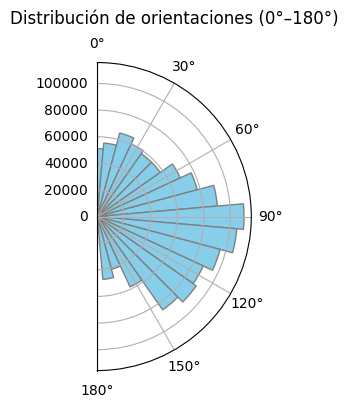

In [ ]:
# Filtrar valores válidos
orientaciones = grid_orientado['orientacion_promedio'].dropna()

# Convertir a radianes (0° a 180° → 0 a π)
orientaciones_rad = np.radians(orientaciones)

# Configurar bins
n_bins = 18  # cada 10°
bins = np.linspace(0, np.pi, n_bins + 1)
counts, _ = np.histogram(orientaciones_rad, bins=bins)
width = np.diff(bins)

# Crear gráfico polar limitado a 0–π
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 4))
ax.bar(bins[:-1], counts, width=width, bottom=0.0, color='skyblue', edgecolor='gray')

# Ajustes de eje
ax.set_theta_zero_location("N")   # 0° arriba
ax.set_theta_direction(-1)        # sentido horario
ax.set_thetalim(0, np.pi)         # limitar a 180°
ax.set_title("Distribución de orientaciones para todo CABA (0°–180°)", y=1.1)

plt.show()


In [19]:
# === 5. Guardado de archivo ===
# Eliminar columna 'centroide' antes de guardar
grid_orientado = grid_orientado.drop(columns='centroide')
# Guardar orientación promedio por celda
grid_orientado.to_file("output/orientacion_promedio.geojson", driver='GeoJSON')
# grid_orientado.to_file("output/orientacion_promedio.shp")